# Exploratory Data Analysis - King County House Market

<img src='https://static.wixstatic.com/media/e5b05f_8e0f67f402404d7a9307fe5115d9f40d~mv2.gif'/>

## Table of Contents
Introduction:

- [Introduction](#intro)
- [The task at hand](#task)
- [Importing Packages and Data](#packages)
- [First glance at the Data](#data)
- [Removing dublicates and Merging Tables](#dublicates)
- [Data Cleaning](#cleaning)
- [Research Questions and Hypothesis Genereation](#hypothesis)


- [xxx](#xxx)








___
<a id='intro'></a>
# Introduction




___
<a id='task'></a>
# The Task at hand

___
<a id='packages'></a>
# Importing Packages and Data

In [390]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from scipy import stats
from matplotlib import patches
from scipy.spatial import ConvexHull


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
plt.rcParams['axes.labelsize'] = 18
plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')

pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [391]:
# importing raw data 
df_details =pd.read_csv('data/king_county_house_details_202301251110.csv')
df_sales =  pd.read_csv('data/king_county_house_sales_202301251111.csv')

___
<a id='data'></a>

# First glance the Data

In [392]:
# check for data types and statistics overview of data frame columns

df_details.head()
df_details.shape
df_details.describe()

df_sales.head()
df_sales.shape
df_sales.describe()

,price,house_id,id
count,21597.000,21597.000,21597.000
mean,540296.574,4580474287.771,10799.000
std,367368.140,2876735715.748,6234.661
min,78000.000,1000102.000,1.000
25%,322000.000,2123049175.000,5400.000
50%,450000.000,3904930410.000,10799.000
75%,645000.000,7308900490.000,16198.000
max,7700000.000,9900000190.000,21597.000


___
<a id='dublicates'></a>
# Removing dublicates and Merging Tables

**Check and remove dublicates:**

In [393]:
#checking for dublicates
df_details.duplicated().value_counts() # no duplicates
df_sales.duplicated().value_counts() # 1690 duplicates

False    21597
dtype: int64

In [394]:
#remove duplicates
df_sales=df_sales.drop_duplicates()
df_sales.reset_index(inplace=True, drop=True)
# remove the id column -> no necessary data 
df_sales.drop('id', axis=1, inplace=True )

In [395]:
df_sales.duplicated().value_counts() # No duplicates anymore 

False    21597
dtype: int64

In [396]:
#renaming the column id to house_id and setting it as index so i can join them
df_details=df_details.rename({'id':'house_id'},axis=1).reset_index()

In [397]:
#merge the tables: 
df=pd.merge(df_details, df_sales, on='house_id')

___
<a id='cleaning'></a>
# Data Cleaning

**Examine the Data Types and change if necessary**

In [398]:
#check data types
df.dtypes
type(df['date'][0]) # Pandas identifies the date as a string --> we need to date time
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
type(df['date'][0]) # It worked

pandas._libs.tslibs.timestamps.Timestamp

**Missing data, any patterns?**

In [399]:
# checking fro missing data
df.isna().sum()

index               0
house_id            0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
dtype: int64

<AxesSubplot:>

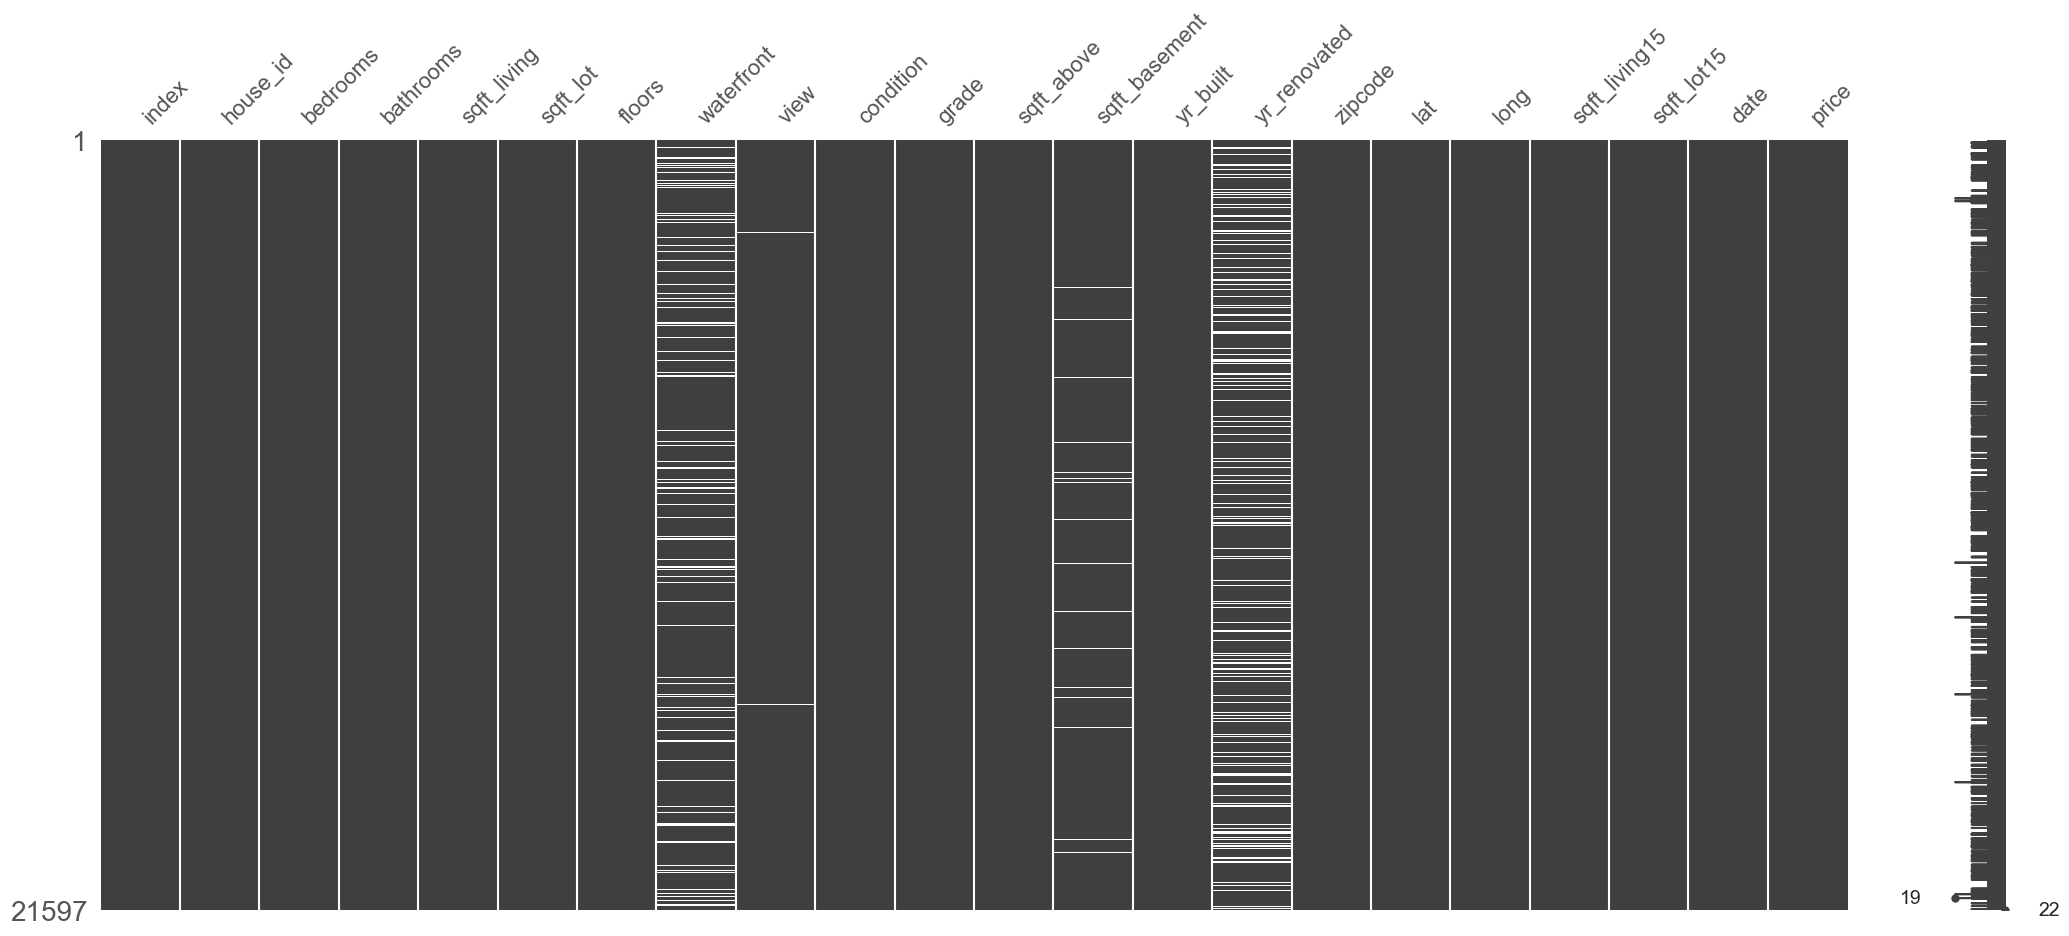

In [400]:
#see if we can find any patterns within the missing data

msno.matrix(df.sort_values('grade')) 

# keep changing the column to sort by and look for patterns
#missing data follows no pattern, i will keep all data, because i dont want to loose any info

Replace or drop missing values

In [401]:
#fill in missing values
df=df.fillna({'waterfront': -1})

___
<a id='hypothesis'></a>
# Research Questions and Hypothesis Genereation


`Question` | Hypothesis | Action/Plot
---|---|---
`What could be Larry Sanders Budget?` | The house-prices are normally distributed and Larrys budget is in the 80%ile. | - Histplot for prices, with defined bandwidth <br/> - Create Budget Categories, based on the distribution of the prices
`Whats the best way to order the filters?` | Price/sqft is a better parameter to depict well priced houses | - Scatterplots to show distribution of prices and sqft-area <br/> - Scatterplots to show the sequence of filtering 
_|Houses that are more central are more expensive|  Create geographical plots that display house prices in the whole county
`Does waterfront increase the price?` | There are houses with waterfronts in Larrys Budget| - Plot each category with the count of Waterfront <br/> - Create sub dataframe with mid-range budget AND waterfront 


___
<a id='Overview'></a>
# First Plots to get an Overview

**Find all the numeric columns in the dataframe and turn to list:**

In [402]:
col_num = df.select_dtypes(include=np.number).columns.tolist()


**Chose the columns you want to plot on histogram and store them in list**

In [403]:
col_plot=['price','sqft_living','sqft_lot','grade','yr_built','condition']

**Build function for the calculation of bin sizes**

In [404]:
def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    returnas can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
    return(result)

In [405]:
#test your function here
freedman_diaconis(df.price, returnas="width")
freedman_diaconis(df.price, returnas="bins")

329

**Build function for plotting histograms:**

In [406]:
def custom_hist_plot(x, bins, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    ax.hist(x, bins, **plt_kwargs)   

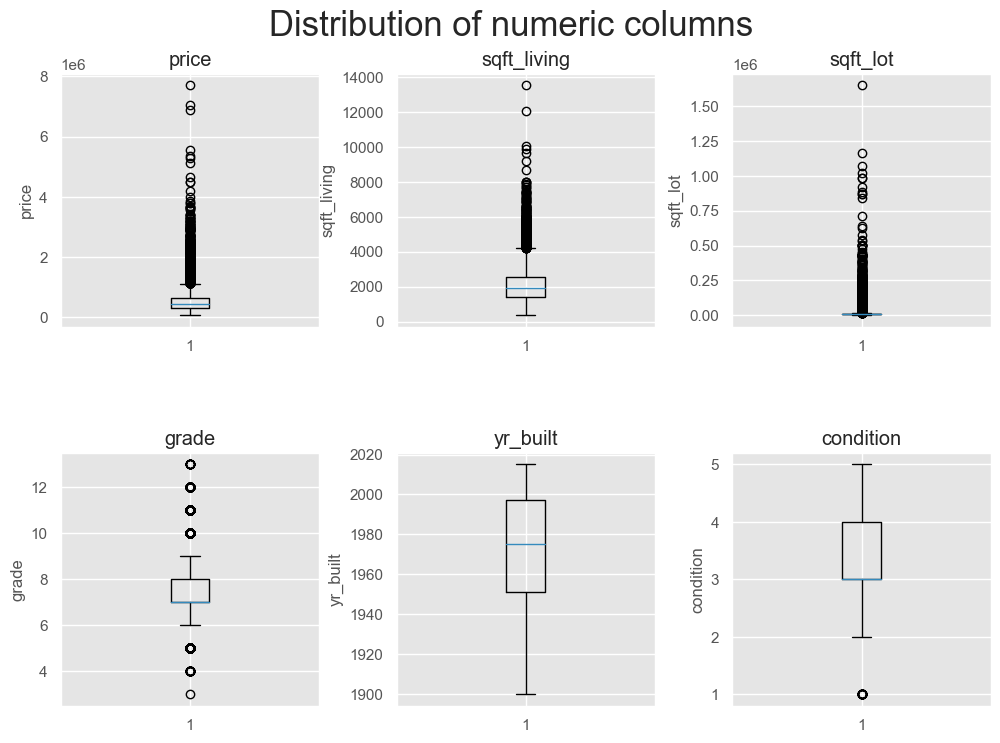

In [407]:
def custom_box_plot(x, ax, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    ax.boxplot(x, **plt_kwargs)  

#Create grid and change axes, size, title as required
fig, [(ax1,ax2, ax3),(ax4,ax5,ax6)]= plt.subplots(2,3, figsize=(12,8))
axes= [ax1, ax2, ax3, ax4, ax5, ax6]
plt.suptitle('Distribution of numeric columns', fontsize=25)
plt.subplots_adjust(hspace = .5, wspace = .3, top = .9)

#iterate over your list and call plotting function in each iteration
i=0
for col in col_plot:
    custom_box_plot(x=df[col], ax = axes[i])
    i+=1

#change axis limits if needed
ax1.set(ylabel=col_plot[0], xlabel= None, title=col_plot[0])    
ax2.set(ylabel=col_plot[1], xlabel= None, title=col_plot[1])    
ax3.set(ylabel=col_plot[2], xlabel= None, title=col_plot[2])
plt.gca().set(xlabel= None)    
ax4.set(ylabel=col_plot[3], xlabel= None, title=col_plot[3])    
ax5.set(ylabel=col_plot[4], xlabel= None, title=col_plot[4])    
ax6.set(ylabel=col_plot[5], xlabel= None, title=col_plot[5])    
plt.show()


    

**Automated Plotting with seaborn**

In [408]:
# Create new dataframe without outliers 
df_filtered=df.query('price < 2e6')

<Figure size 800x500 with 0 Axes>

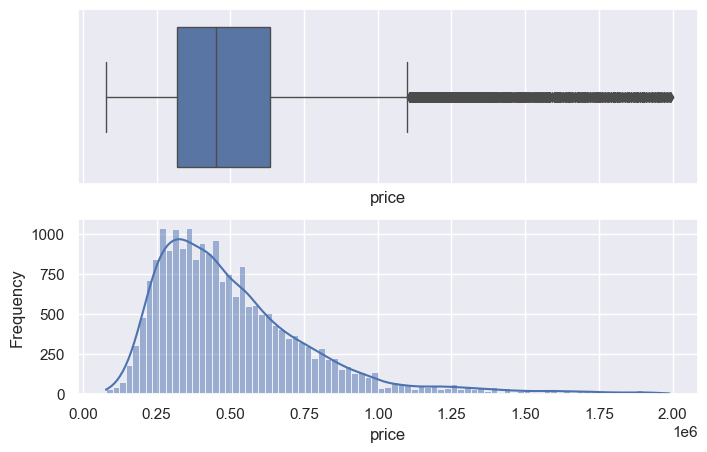

<Figure size 800x500 with 0 Axes>

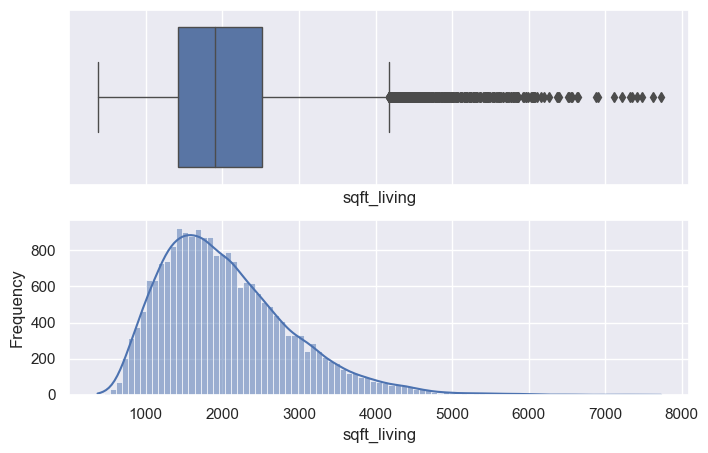

<Figure size 800x500 with 0 Axes>

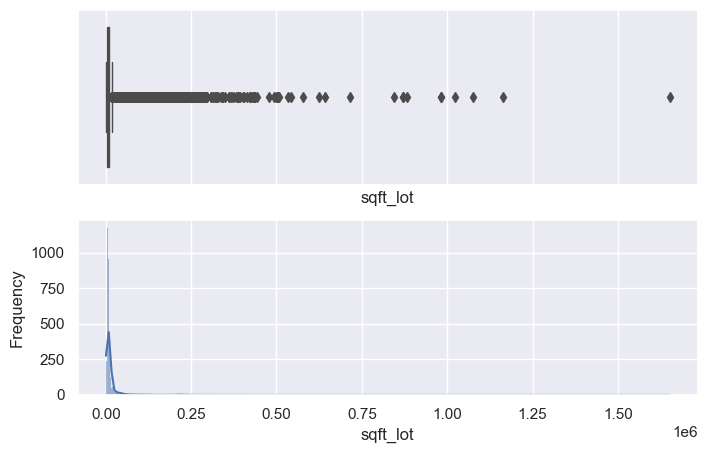

<Figure size 800x500 with 0 Axes>

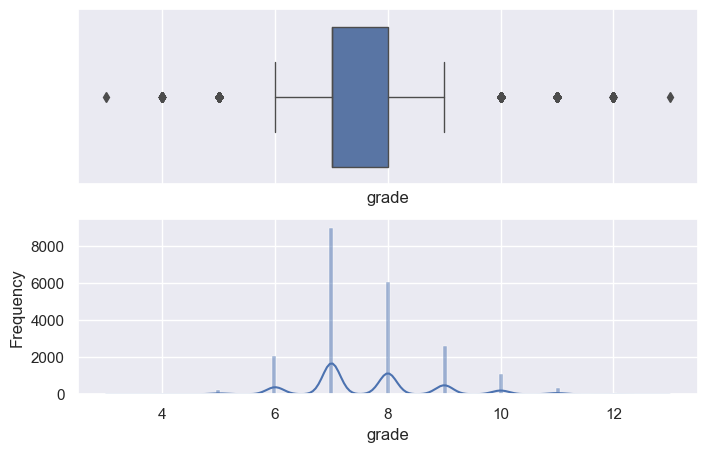

<Figure size 800x500 with 0 Axes>

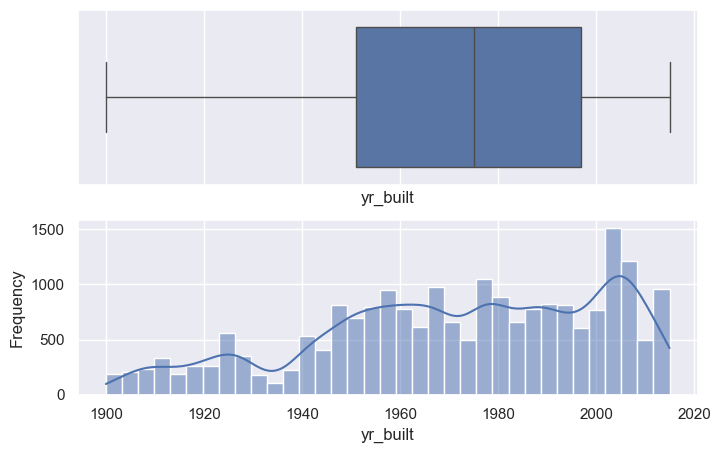

<Figure size 800x500 with 0 Axes>

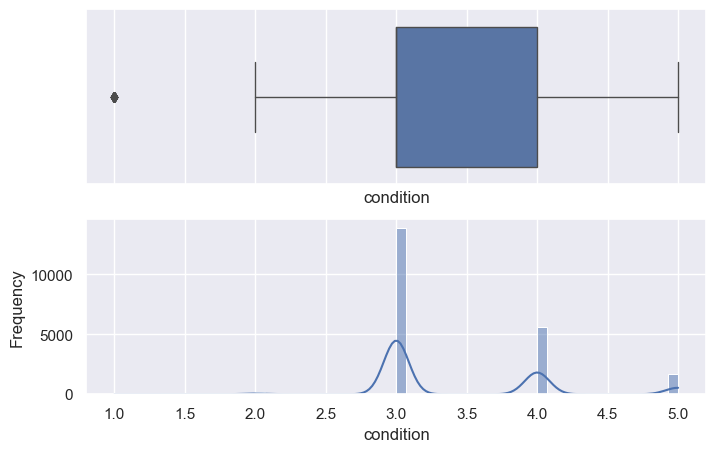

In [409]:
for col in col_plot:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})

    NBR_BINS = freedman_diaconis(df_filtered[col], returnas="bins")

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    
    plt.gca().set(xlabel= col,ylabel='Frequency')
    sns.boxplot(df_filtered[col], ax=ax_box , linewidth= 1.0)
    sns.histplot(df_filtered[col], ax=ax_hist , bins = NBR_BINS, kde=True)



Plot the histograms again to see the filtered data distribution.

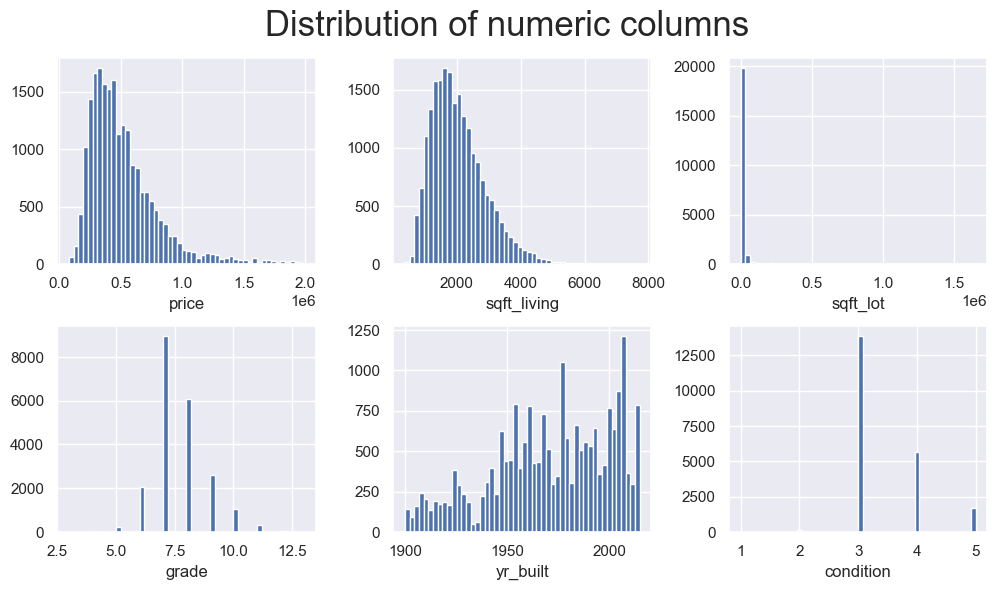

In [410]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
plt.suptitle('Distribution of numeric columns', fontsize=25)
plt.rcParams['axes.labelsize'] = 15
plt.subplots_adjust(hspace = .5, wspace = .8, top = .9)

for xcol, ax in zip(['price','sqft_living','sqft_lot','grade','yr_built','condition'], axes.ravel()):
    #NBR_BINS = freedman_diaconis(df_filtered[xcol], returnas="bins")
    df_filtered.hist(column=xcol, ax=ax, bins=50)
    ax.set(xlabel=xcol) 
    ax.set(title=None)
plt.show()


# Create price bins 

Create bins for the different price categories and create a new column to store those categories. The function qcut takes the number of elements you feed into the labels-argument and creates bins with the same number of samples so statistical analysis is feasable. 

In [411]:
bin_labels = ['Low', 'low-mid', 'mid', 'mid-high', 'high']
df_filtered['price_category'] = pd.qcut(df_filtered['price'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels)

**Create new columns for price/sqft living and price/sqft lot**
**create new column again for each parameter to assign a category**

In [412]:
df_filtered['price_per_sqft_living']=df_filtered['price'] / df_filtered['sqft_living']
df_filtered['p_per_sqft_living_category'] = pd.qcut(df_filtered['price_per_sqft_living'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels)


df_filtered['price_per_sqft_lot']=df_filtered['price'] / df_filtered['sqft_lot']
df_filtered['p_per_sqft_lot_category'] = pd.qcut(df_filtered['price_per_sqft_lot'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels)  

Plot new parameteres with respective bin categories!

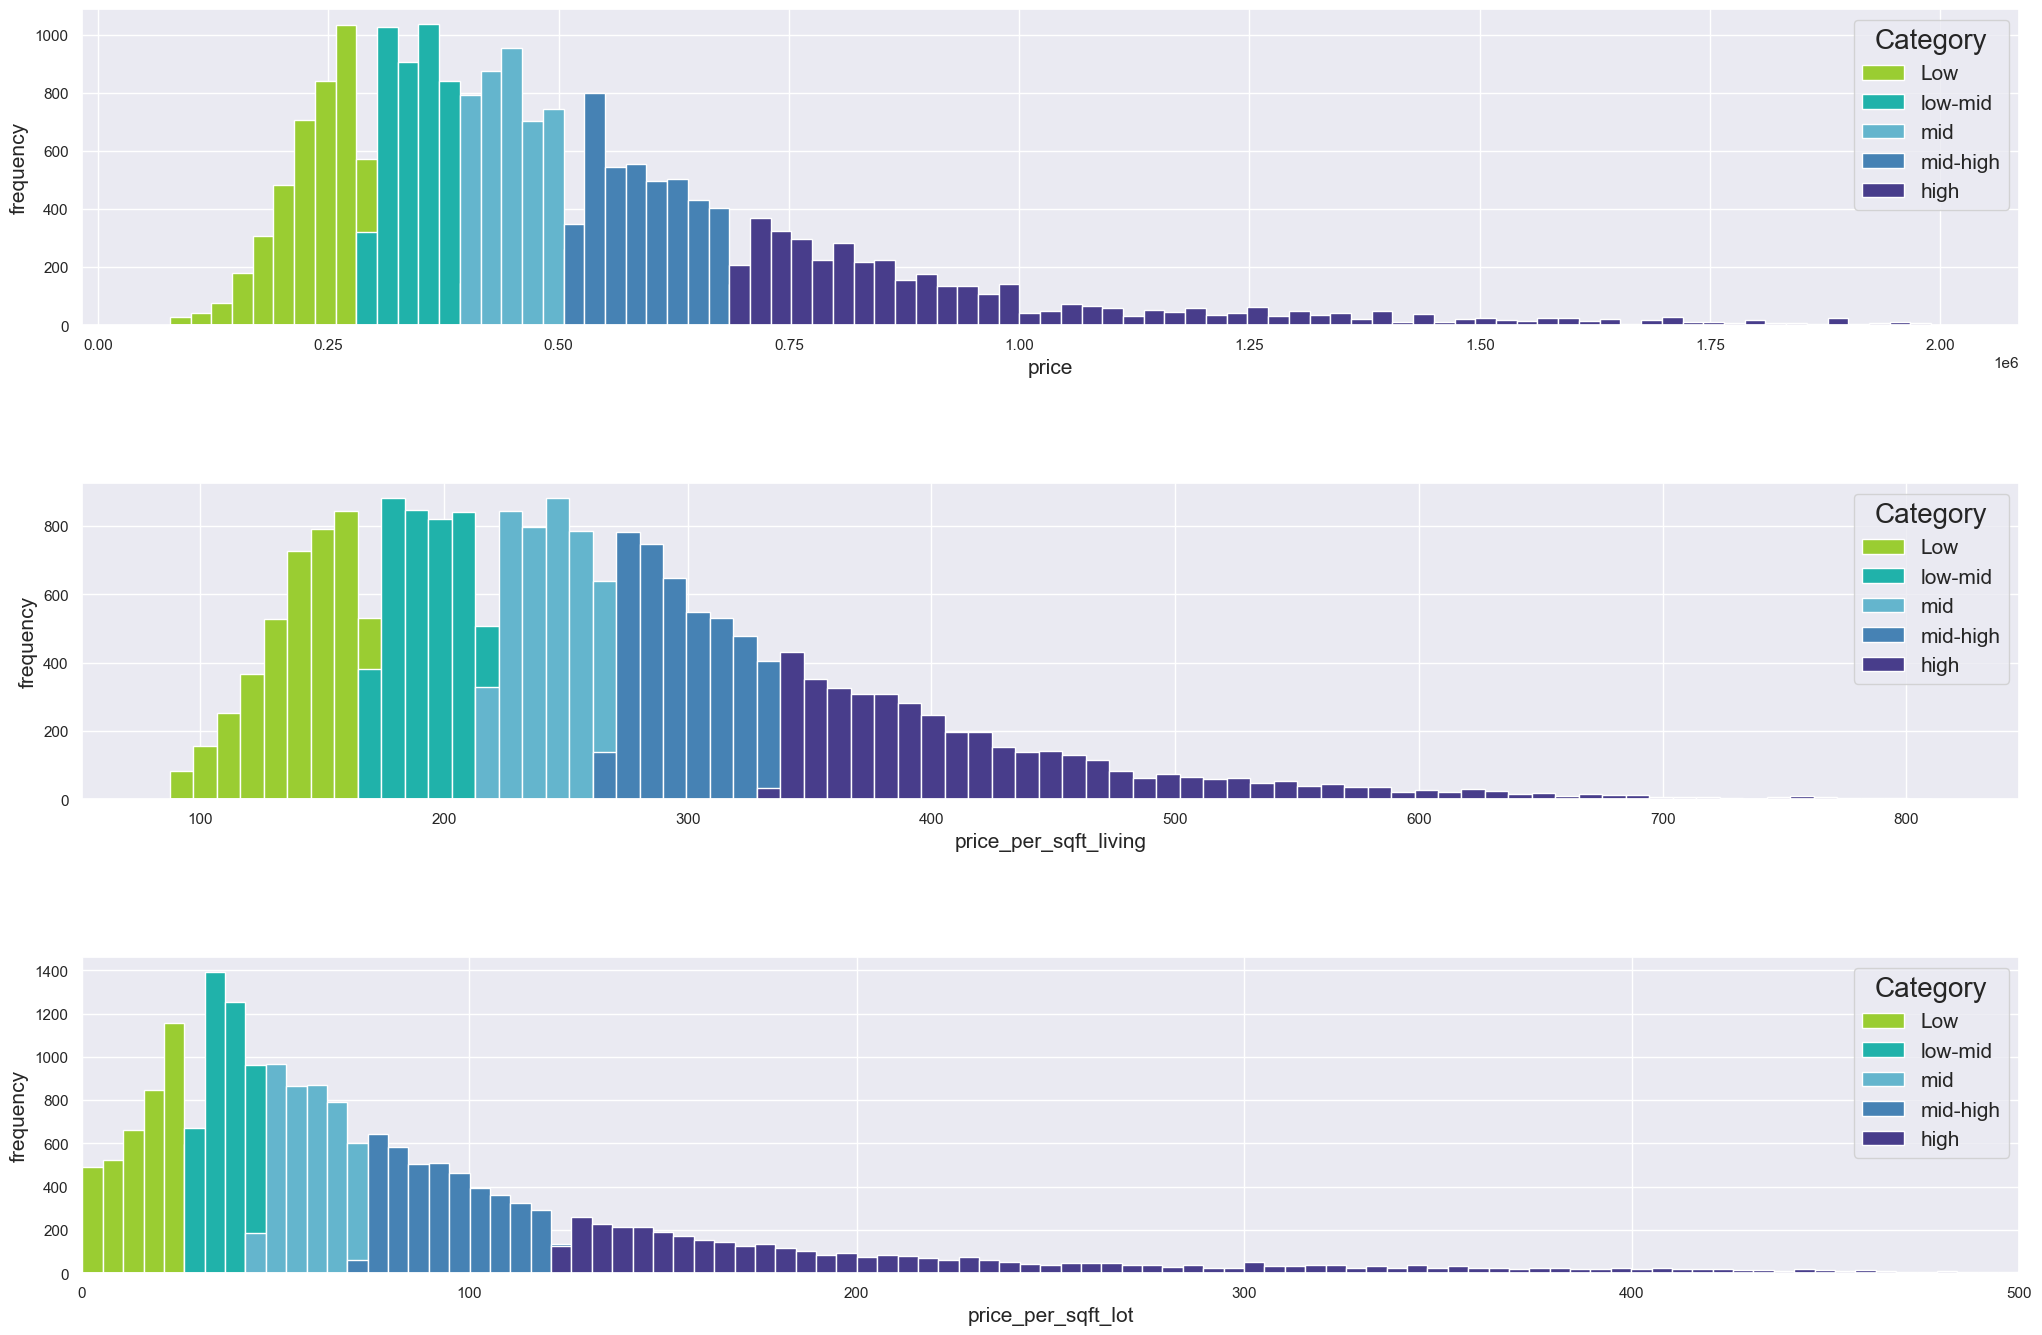

In [413]:
col_x=['price', 'price_per_sqft_living', 'price_per_sqft_lot']
col_cat=['price_category', 'p_per_sqft_living_category', 'p_per_sqft_lot_category']

fig, [(ax1),(ax2),(ax3)]= plt.subplots(3, figsize=(25,16))
axes= [ax1, ax2, ax3]


plt.subplots_adjust(hspace = .5, wspace = .3, top = .9)
plt.rcParams['axes.labelsize'] = 20
plt.rc('legend',fontsize=15, title_fontsize=20, )

for i, col in enumerate(col_x):
    NBR_BINS = freedman_diaconis(df_filtered[col], returnas="bins")
    df_filtered.pivot(columns=col_cat[i], values=col_x[i]).plot.hist(color=['yellowgreen','lightseagreen', 'c', 'steelblue', 'darkslateblue'], ax = axes[i], bins=NBR_BINS)


#change axis limits if needed
ax1.set(xlabel=col_x[0], ylabel='frequency',)
ax2.set(xlabel=col_x[1], ylabel='frequency')
ax3.set(xlabel=col_x[2], ylabel='frequency', xlim=(0,500))
ax1.legend(title='Category')
ax2.legend(title='Category')
ax3.legend(title='Category')

plt.show()


Show the scatter distribution and mark the houses in the clients price range: 0-700.000$

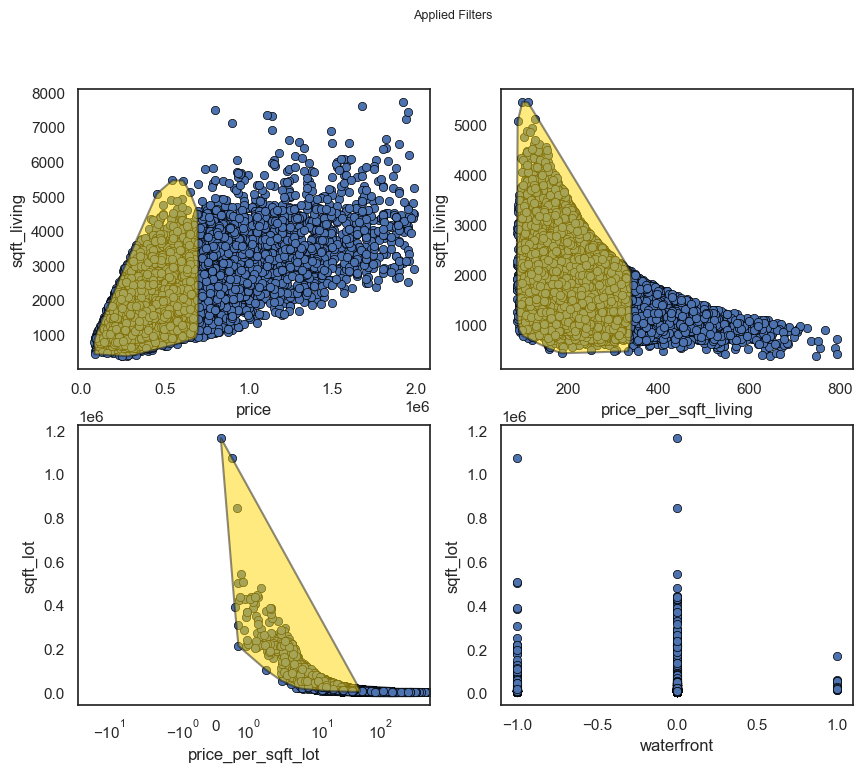

In [414]:
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

df_700=df_filtered.query('price<700000')
df_living=df_700.query('price_per_sqft_living < 340')
df_lot=df_living.query('price_per_sqft_lot < 45')
df_lot['waterfront'] = df_lot['waterfront'].fillna(-1)

sns.set_style("white")
plt.rcParams['axes.labelsize'] = 12
#plt.subplots_adjust(hspace = .9, wspace = .9, top = .8)



fig,[(ax1, ax2),(ax3, ax4)] = plt.subplots(2,2,figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')    
plt.suptitle('Applied Filters', fontsize=9) 

ax1.scatter('price','sqft_living', data=df_filtered, edgecolors='black', linewidths=.5)
df_encircle_data = df_filtered.loc[df_filtered.price < 700000]                         
encircle(df_encircle_data.price, df_encircle_data.sqft_living, ec="k", fc="gold", alpha=0.5, linewidth=1.5, ax=ax1)
ax1.set(xlabel='price', ylabel='sqft_living', xlim=None)

ax2.scatter('price_per_sqft_living','sqft_living', data=df_700, edgecolors='black', linewidths=.5)
df_encircle_data = df_700.loc[df_700.price_per_sqft_living < 340]                         
encircle(df_encircle_data.price_per_sqft_living, df_encircle_data.sqft_living, ec="k", fc="gold", alpha=0.5, linewidth=1.5, ax=ax2)
ax2.set(xlabel='price_per_sqft_living', ylabel='sqft_living', xlim=None)

ax3.scatter('price_per_sqft_lot','sqft_lot', data=df_living, edgecolors='black', linewidths=.5)
df_encircle_data = df_living.loc[df_living.price_per_sqft_lot < 45]                         
encircle(df_encircle_data.price_per_sqft_lot, df_encircle_data.sqft_lot, ec="k", fc="gold", alpha=0.5, linewidth=1.5, ax=ax3)
ax3.set(xlabel='price_per_sqft_lot', ylabel='sqft_lot', xlim=None)
ax3.set_xscale('symlog')

ax4.scatter('waterfront','sqft_lot', data=df_lot, edgecolors='black', linewidths=.5)
ax4.set(xlabel='waterfront', ylabel='sqft_lot', xlim=None)




plt.show()    



Filter the Houses accoring to the clients wishes:

In [415]:
list1=['low-mid', 'mid', 'mid-high']

df_client=df_filtered[df_filtered['price_category'].isin(list1)]
df_client=df_client[df_client['p_per_sqft_living_category'].isin(list1)]
df_client=df_client.query('waterfront == 1')
df_client=df_client.query('bedrooms > 2')

df_client.shape

(7, 27)

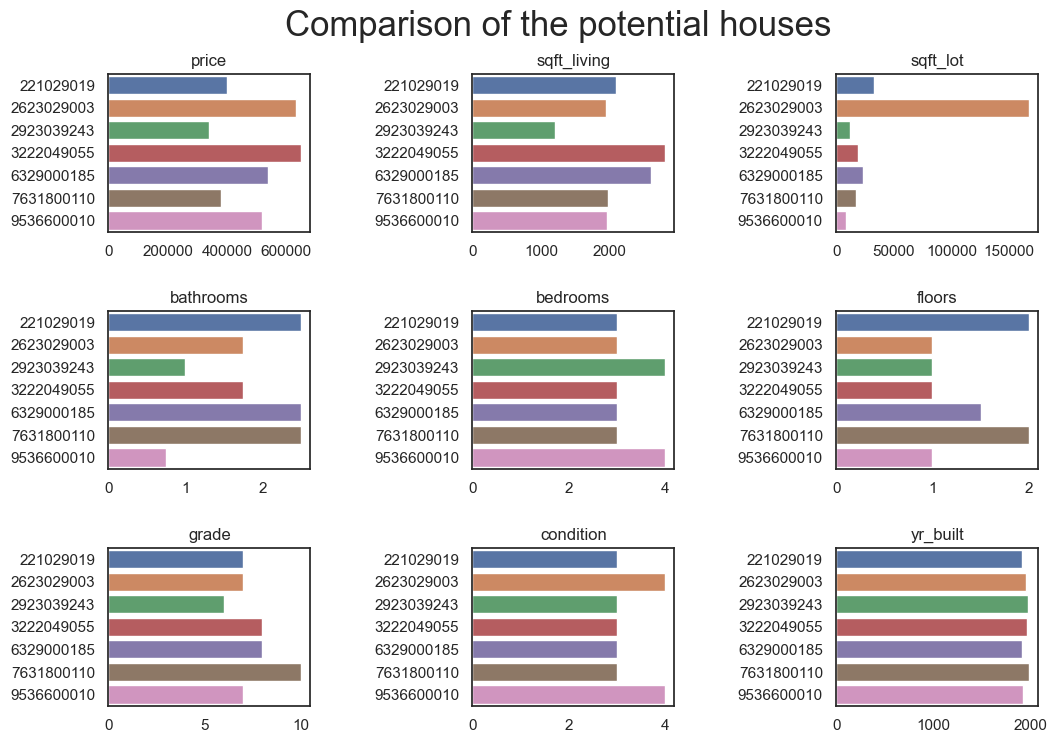

In [416]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,8))
plt.suptitle('Comparison of the potential houses', fontsize=25)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(hspace = .5, wspace = .8, top = .9)

for xcol, ax in zip(['price','sqft_living','sqft_lot','bathrooms','bedrooms','floors','grade','condition','yr_built'], axes.ravel()):
    sns.barplot(data=df_client, y='house_id', x=xcol, ax=ax, orient='h')
    ax.tick_params(labelrotation=None)
    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_title(xcol)

plt.show()


In [452]:
from plotly.subplots import make_subplots

import plotly.graph_objects as go
fig = make_subplots(
    rows=1, cols=2, subplot_titles=('All Houses', 'Houses in the budget'),
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}]])

fig.add_trace(
    go.Scattermapbox(
        lat=df_filtered.lat,
        lon=df_filtered.long,
        mode='markers',
        marker=dict(
            size=4
        ),
        text=['Houses'],
        subplot='mapbox',
    ))
fig.add_trace(  
    go.Scattermapbox(
        lat=df_lot.lat,
        lon=df_lot.long,
        mode='markers',
        marker=dict(
            size=4
        ),
        text=['Houses'],
        subplot='mapbox2',
    ))

fig.update_layout(
    autosize=True,
    #hovermode='closest',
    mapbox=dict(
        style='open-street-map',
        domain={'x': [0, 0.4], 'y': [0, 1]},
        bearing=0,
        center=dict(
            lat=47.49,
            lon=-122.3
        ),
        pitch=0,
        zoom=8
    ),
        mapbox2=dict(
        style='open-street-map',
        domain={'x': [0.6, 1.0], 'y': [0, 1]},
        bearing=0,
        center=dict(
            lat=47.49,
            lon=-122.3
        ),
        pitch=0,
        zoom=8
    ),
)

In [444]:
df_wf=df_lot.query('waterfront==1')
df_br=df_wf.query('bedrooms >2')

In [453]:
from plotly.subplots import make_subplots

import plotly.graph_objects as go
fig = make_subplots(
    rows=1, cols=2, subplot_titles=('Houses with waterfront', 'Houses with > 2 Bedrooms'),
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}]])

fig.add_trace(
    go.Scattermapbox(
        lat=df_wf.lat,
        lon=df_wf.long,
        mode='markers',
        marker=dict(
            size=8
        ),
        text=['Houses'],
        subplot='mapbox',
    ))
fig.add_trace(  
    go.Scattermapbox(
        lat=df_br.lat,
        lon=df_br.long,
        mode='markers',
        marker=dict(
            size=8
        ),
        text=['Houses'],
        subplot='mapbox2',
    ))

fig.update_layout(
    autosize=True,
    #hovermode='closest',
    mapbox=dict(
        style='open-street-map',
        domain={'x': [0, 0.4], 'y': [0, 1]},
        bearing=0,
        center=dict(
            lat=47.49,
            lon=-122.3
        ),
        pitch=0,
        zoom=8
    ),
        mapbox2=dict(
        style='open-street-map',
        domain={'x': [0.6, 1.0], 'y': [0, 1]},
        bearing=0,
        center=dict(
            lat=47.49,
            lon=-122.3
        ),
        pitch=0,
        zoom=8
    ),
)